# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

# [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import re
import string
from nltk.corpus import stopwords            #importing stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import math
import pickle



In [2]:
data = pd.read_csv('Reviews.csv')
print (data.head(2))
print(data.shape)

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
(568454, 10)


## [2] Data Cleaning: Deduplication and Nan features

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#checking for Nan values in data. True indicates Nan values are present along the columns
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

In [4]:
# checking for Nan values along 'profilename' column
#data[data['ProfileName'].isnull()].head()

In [5]:
# checking for Nan values along 'summary' column
#data[data['Summary'].isnull()]

In [6]:
#Dropping Nan values
data = data.dropna()

In [7]:
#printing shape of data after dropping Nan values
print (data.shape)

(568411, 10)


In [8]:
#Review score should lie between 1 to 5
#Returns True if all the scores lie between 1 to 5(inclusive)
list1 = data['Score'].map(lambda x: True if x in [1,2,3,4,5] else False)
list1.all()

True

In [9]:
filtered_data = data.loc[data['Score']!=3].copy()
#print (filtered_data.head())
print (filtered_data.shape)

(525773, 10)


In [10]:
#mapping positive(>3) and negative(<3) reviews based on scores of the data.
pos_negative = filtered_data['Score'].map(lambda x: 1 if int (x)>3  else 0)
filtered_data['Score'] = pos_negative
print ('shape of filtered_data')
print (filtered_data.shape)
print (filtered_data.head(2))


shape of filtered_data
(525773, 10)
   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      1  1303862400  Good Quality Dog Food   
1                       0      0  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  


In [11]:
#arranging data with increasing productid
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort')

In [12]:
#finding the duplicates in our data
#If the same person gives for the same product at the same time we call it as suplicates
#sorted_data.loc[sorted_data.duplicated(["UserId","ProfileName","Time","Text"],keep = False),:]

In [13]:
#counting number of duplicates present in our data
sorted_data.duplicated(["UserId","ProfileName","Time","Text"]).sum()

161612

In [14]:
#dropping all duplicates keeping the first one
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)
final.shape

(364161, 10)

In [15]:
#helpfulness numerator denotes number of people who found the review helpful
#helpfulness denominator denotes number of people who indicated whether or not the review helpful
#so, helpfulness numerator should be less than denominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#final shape of data after preprocessing
final.shape

(364159, 10)

In [17]:
#arranging data with increasing productid
final = final.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort')

In [18]:
final['Score'].value_counts()

1    307054
0     57105
Name: Score, dtype: int64

In [19]:
final_data = final.iloc[0:100000,:].copy()

In [20]:
final_data.shape

(100000, 10)

In [21]:
final_data['Score'].value_counts()

1    87730
0    12270
Name: Score, dtype: int64

#  [3] Preprocessing

# [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [98]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
not_words = re.findall(r'\w*n[\'|o]t',str (stop)) #finding NOT words in stop words
not_words.append('n\'t')
not_words.append('no')
print (not_words)
stop_words = stop - set (not_words)  #removing  NOT words from stop words
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r'\w*n[\'|o]t', "not", phrase)
    # general
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def cleanhtmlpunc(sentence): #function to clean the word of any html-tags
    clean = re.compile('<.*?>')
    clean = re.sub(clean, ' ', sentence)
    clean = re.sub(r"(http|www)\S+", "", clean)
    clean = re.sub(r"\S+com", "",clean)
    #clean = re.sub(r"\(\w+\)","",clean)
    clean = re.sub(r"\."," ",clean)
    cleaned = re.sub(r'[?+|!+|\'+|"+|#+|:+]',r' ',clean)
    cleantext = re.sub(r'[\.+|,+|)+|(+|\+|/+]',r' ',cleaned)
    return cleantext
#def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
   # return  cleaned
print('************************************')                 
print(stop_words)

["weren't", "didn't", "won't", "aren't", "hadn't", "wouldn't", "mustn't", "couldn't", "mightn't", 'not', "hasn't", "doesn't", "isn't", "don't", "shouldn't", "wasn't", "haven't", "shan't", "needn't", "n't", 'no']
************************************
{'how', 'before', 'yourselves', 'if', 'is', 'have', 'during', 'same', 'our', 'some', 'hers', 'won', 'up', 'by', 'into', 'in', 'again', 'been', 'herself', 'doing', 'mustn', 'ain', 'she', 'them', 'm', 'their', 's', 'her', 'which', 'didn', "you've", 'having', 'being', "that'll", 'don', 'are', 'once', 'itself', 'for', 'from', 'those', 'that', 'more', 've', 're', 'at', 'while', 'd', 'until', 'when', 'where', "you'll", 'because', 'him', 'ourselves', 'his', 'here', 'all', 'about', 'weren', 'why', 'own', 'now', 'aren', "she's", 'but', 'very', 'these', 'shouldn', 'few', 'am', 'yourself', 't', 'myself', "you'd", 'any', 'so', 'and', 'this', 'doesn', 'there', 'through', 'out', 'under', 'were', 'mightn', 'we', 'theirs', 'ma', 'most', 'ours', 'does', 'y',

In [23]:
def cleanedtext(reviews):
    str1=' '
    final_string=[]
    s=''
    for sent in reviews:
        filtered_sentence=[]    
        sent=cleanhtmlpunc(decontracted(sent)) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in w.split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if((cleaned_words.lower() not in stop_words)):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words for reviews
        final_string.append(str1)
    return final_string

In [24]:
final_string = cleanedtext(final_data['Text'].values)

# Applying Logistic Regression

# [4.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

## [4.1.1] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [2]:
import pickle 
with open("final_data.pkl", "rb") as f:
    final_data = pickle.load(f)

In [3]:
final_data = final_data.iloc[0:100000,:]

In [4]:
final_data.shape

(100000, 13)

In [5]:
#https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions

In [5]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, final_data['Score'].values, 
                                                             test_size=0.3, random_state=42,shuffle=False)


In [6]:
model = CountVectorizer(dtype=float)
final_counts= model.fit_transform(X_train)

In [7]:
#standardizing the bag of words
standardizing  = StandardScaler(with_mean = False)
final_std_data = standardizing.fit_transform(final_counts)
final_std_data.shape

(70000, 31094)

train scores
[0.8872166258768911, 0.9032958584075139, 0.9055026416848345, 0.9060861740180313, 0.906182462039576, 0.9076561973239293, 0.9076352511159531, 0.9075823481330635, 0.907588009805383, 0.9075770724838569, 0.9076136278828254, 0.9075545227952586, 0.9075756986374968]
**************************************************
CV scores
[0.7675376832793198, 0.786533751980348, 0.7891311431371723, 0.791253547700876, 0.7912544583195009, 0.7913648510317012, 0.7913332664226604, 0.7916902685156977, 0.7913894377345709, 0.7913989398419602, 0.7914336225339309, 0.7916936635394836, 0.7913844689242486]


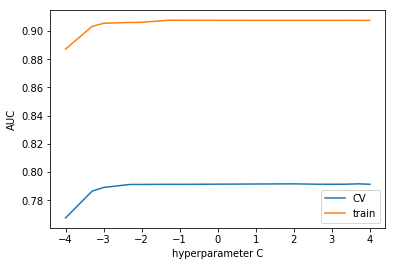

In [10]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,solver='saga',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, final_std_data, y_train, cv=10, scoring=auc)
    log_reg.fit(final_std_data,y_train)
    y_pred_proba = log_reg.predict_proba(final_std_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [11]:
log_reg = LogisticRegression(C=100,solver='saga',max_iter=10000,tol=0.001,n_jobs=-1)
log_reg.fit(final_counts,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=-1, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [12]:
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(model.transform(X_test), y_test)*100))

accuracy = 92.5


In [13]:
predictions = log_reg.predict(standardizing.transform(model.transform(X_test)))

In [14]:
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

precision = 0.9666765843498959
Recall=0.8781081081081081
f1_score=0.9202662512392012


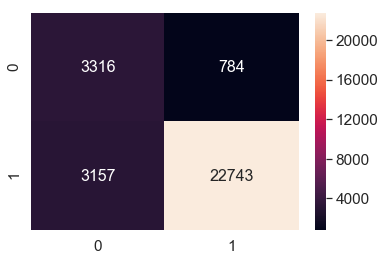

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

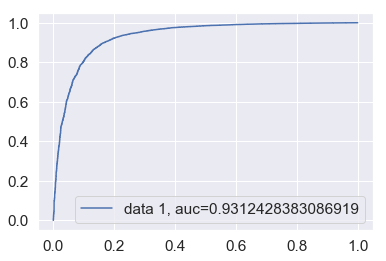

In [16]:
y_pred_proba = log_reg.predict_proba(model.transform(X_test))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### [4.1.1.1] Pertubation Test

In [17]:
#clf = LogisticRegression(C=model.best_params_['C'], penalty='l2')
#clf.fit(final_std_data, y_train)
weights_before = log_reg.coef_
print ('weights_before={0}'.format(weights_before))

weights_before=[[ 1.67703901e-02  5.14711165e-03 -5.38907139e-02 ...  6.79927908e-03
   6.29820289e-05  6.85599065e-04]]


In [18]:
from scipy.sparse import find
eps = np.random.normal(scale=0.01)
print ('noise adding to weight vector is = {0}'.format(eps))
X_train1 = final_counts
a,b,c = find(X_train1)
X_train1[a,b] = X_train1[a,b]+eps
log_reg.fit(X_train1,y_train)
weights_after = log_reg.coef_
print ('weights_after adding noise = {0}'.format(weights_after))

noise adding to weight vector is = 0.006139962498737992
weights_after adding noise = [[ 1.66861339e-02  5.18499791e-03 -5.34311971e-02 ...  6.90404251e-03
   4.97940225e-05  7.01490370e-04]]


In [19]:
per_weights_diff = abs((weights_before - weights_after)/weights_before)*100
per_weights_diff = per_weights_diff[0]

In [20]:
for i in range(0,110,10):
    print ('{0}  percentile value is {1}'.format(i,np.percentile(per_weights_diff,i)))

0  percentile value is 0.00016873855680106447
10  percentile value is 0.17566958318672576
20  percentile value is 0.3708582422088057
30  percentile value is 0.588400474177819
40  percentile value is 0.8893549312443004
50  percentile value is 1.3493502065878444
60  percentile value is 2.144811872848045
70  percentile value is 3.7624360694869883
80  percentile value is 7.594158041619698
90  percentile value is 21.302181988035613
100  percentile value is 1359298.8626627645


In [21]:
for i in range(0,11,1):
    print ('{0}  percentile value is {1}'.format(60+i,np.percentile(per_weights_diff,60+i)))

60  percentile value is 2.144811872848045
61  percentile value is 2.254222670672485
62  percentile value is 2.370316193944895
63  percentile value is 2.494914457111536
64  percentile value is 2.6422856736299014
65  percentile value is 2.786969047610154
66  percentile value is 2.959162340942017
67  percentile value is 3.1436518761189367
68  percentile value is 3.3479251476185516
69  percentile value is 3.5527140753665396
70  percentile value is 3.7624360694869883


In [22]:
for i in range(0,11,1):
    print ('{0}  percentile value is {1}'.format(63+i*0.1,np.percentile(per_weights_diff,63+i*0.1)))

63.0  percentile value is 2.494914457111536
63.1  percentile value is 2.513683703079929
63.2  percentile value is 2.53208235928024
63.3  percentile value is 2.5436407867107893
63.4  percentile value is 2.5554346956896175
63.5  percentile value is 2.573439426220451
63.6  percentile value is 2.5871164719424375
63.7  percentile value is 2.6020419986022927
63.8  percentile value is 2.6134030229436798
63.9  percentile value is 2.629241177161071
64.0  percentile value is 2.6422856736299014


In [23]:
feat_names = model.get_feature_names()

In [24]:
per_weights_diff[per_weights_diff>2.5].size

11492

In [25]:
(per_weights_diff[per_weights_diff>2.5].size)*100/weights_before.size

36.958898822924034

In [26]:
index = per_weights_diff>2.5

In [27]:
colli_features = [feature for feature,bol in zip(feat_names,index) if bol==True]

In [28]:
colli_features[0:10]

['aaaah',
 'aaah',
 'aad',
 'aadp',
 'aahh',
 'ab',
 'abandon',
 'abaolut',
 'abba',
 'abbi']

### [4.1.1.2] Feature Importance

In [29]:
indices = list (np.argsort(weights_before[0]))

In [30]:
pos_indices = indices[-10:]
neg_indices = indices[0:10]

In [31]:
print ('top 10 positive features\t\t\ttop 10 negative features')
print ('-'*100)
for id1,id2 in zip(pos_indices,neg_indices):
    print ('\t{0}\t\t\t\t\t\t{1}'.format(feat_names[id1],feat_names[id2]))
   

top 10 positive features			top 10 negative features
----------------------------------------------------------------------------------------------------
	awesom						worst
	fantast						terribl
	yummi						aw
	addict						bland
	great						horribl
	amaz						disappoint
	best						threw
	perfect						unfortun
	excel						stale
	delici						tasteless


## [4.1.2] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

train scores
[0.5, 0.7940562566329163, 0.8592942388920859, 0.9422173038918453, 0.9645540175998825, 0.9885241178332582, 0.9928626256579467, 0.9974313517282255, 0.9974143330579701, 0.9974815980802576, 0.9974500075323999, 0.9974115972428843, 0.9974195790130913]
**************************************************
CV scores
[0.5, 0.719741226931902, 0.8386816934576604, 0.9158721469675113, 0.9254130744246624, 0.9205910172223717, 0.909485379721038, 0.8308710205718646, 0.8283735599110841, 0.8260575598073526, 0.8254888685781344, 0.8232855773252796, 0.8247266609931166]


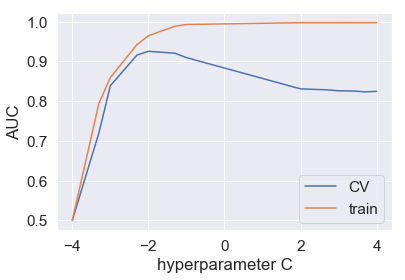

In [32]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l1',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, final_std_data, y_train, cv=10, scoring=auc)
    log_reg.fit(final_std_data,y_train)
    y_pred_proba = log_reg.predict_proba(final_std_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [ ]:
#http://rnowling.github.io/data/science/2016/09/04/comparing-lr-regularization-and-optimizers.html

In [33]:
log_reg = LogisticRegression(C=0.005,penalty='l1',max_iter=5000,tol=0.001)
log_reg.fit(final_counts,y_train)

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [34]:
predictions = log_reg.predict(standardizing.transform(model.transform(X_test)))

In [36]:
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(model.transform(X_test)), y_test)*100))

accuracy = 87.34666666666666


In [37]:
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

precision = 0.8935617121287658
Recall=0.9688416988416988
f1_score=0.9296802637916342


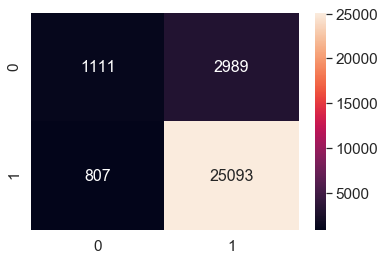

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

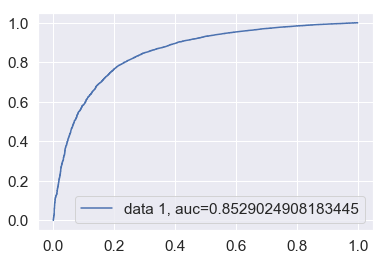

In [39]:
y_pred_proba = log_reg.predict_proba(model.transform(X_test))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### [4.1.2.1] Pertubation Test

In [40]:
from scipy.sparse import find
weights_before = log_reg.coef_
print ('weights_before={0}'.format(weights_before))
eps = np.random.normal(scale=0.01)
print ('noise adding to weight vector is = {0}'.format(eps))
X_train1 = final_counts
a,b,c = find(X_train1)
X_train1[a,b] = X_train1[a,b]+eps
log_reg.fit(X_train1,y_train)
weights_after = log_reg.coef_
print ('weights_after adding noise = {0}'.format(weights_after))

weights_before=[[0. 0. 0. ... 0. 0. 0.]]
noise adding to weight vector is = -0.013766085204073575
weights_after adding noise = [[0. 0. 0. ... 0. 0. 0.]]


In [41]:
weights_before = weights_before[0]+0.000001

In [42]:
weights_after = weights_after[0]+0.000001

In [43]:
per_weights_diff = abs((weights_before - weights_after)/weights_before)*100
per_weights_diff = per_weights_diff[0]

In [44]:
for i in range(0,110,10):
    print ('{0}  percentile value is {1}'.format(i,np.percentile(per_weights_diff,i)))

0  percentile value is 0.0
10  percentile value is 0.0
20  percentile value is 0.0
30  percentile value is 0.0
40  percentile value is 0.0
50  percentile value is 0.0
60  percentile value is 0.0
70  percentile value is 0.0
80  percentile value is 0.0
90  percentile value is 0.0
100  percentile value is 0.0


In [45]:
(per_weights_diff[per_weights_diff>2.5].size)*100/weights_before.size

0.0

### [4.1.2.2] Calculating sparsity on L1 regulrization 

In [46]:
print ('Hyper Parameters(C) \t Num of non Zero elments')
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
for c in alpha_values:
    clf = LogisticRegression(C=c, penalty='l1',tol=0.01)
    clf.fit(final_counts, y_train)
    w = clf.coef_
    print ('\t{0}\t\t\t{1}'.format(c,np.count_nonzero(w)))

Hyper Parameters(C) 	 Num of non Zero elments
	0.0001			0
	0.0005			2
	0.001			7
	0.005			51
	0.01			118
	0.05			451
	0.1			744
	100			13555
	500			15953
	1000			16784
	2500			19333
	5000			20597
	10000			23894


### [4.1.2.3]Feature Importance

In [48]:
feat_names = model.get_feature_names()
weights_before = log_reg.coef_
indices = list (np.argsort(weights_before[0]))
pos_indices = indices[-10:]
neg_indices = indices[0:10]
print ('top 10 positive features\t\t\ttop 10 negative features')
print ('-'*100)
for id1,id2 in zip(pos_indices,neg_indices):
    print ('\t{0}\t\t\t\t\t{1}'.format(feat_names[id1],feat_names[id2]))
   

top 10 positive features			top 10 negative features
----------------------------------------------------------------------------------------------------
	find					disappoint
	favorit					money
	excel					bad
	good					not
	nice					product
	perfect					thought
	love					would
	delici					tast
	best					receiv
	great					bought


# [4.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

 ### [4.2.1] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [49]:
# split the data set into train and test
tfidf_train, tfidf_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, final_data['Score'].values, 
                                                             test_size=0.3, random_state=0,shuffle=False)


In [50]:
vector = TfidfVectorizer(ngram_range = (1,1))
tf_idf_vector = vector.fit_transform(tfidf_train)

In [51]:
standardizing  = StandardScaler(with_mean = False)
final_std_data = standardizing.fit_transform(tf_idf_vector)
final_std_data.shape

(70000, 31094)

train scores
[0.9801327058379166, 0.989632704947094, 0.9918192724909438, 0.9947721691588912, 0.9954147610487238, 0.9964227208453073, 0.9965977417449947, 0.997237863086906, 0.997050441937076, 0.9970504557943157, 0.9970714000226862, 0.9970705527514442, 0.9970716059016796]
**************************************************
CV scores
[0.9092294068052114, 0.9140867851223128, 0.910187268720191, 0.893801488307162, 0.8852491462455492, 0.8653360746913151, 0.8536385449818876, 0.8236376996902512, 0.8223429583742371, 0.8238000768482936, 0.8229355731384134, 0.8231812224104826, 0.8230192312755531]


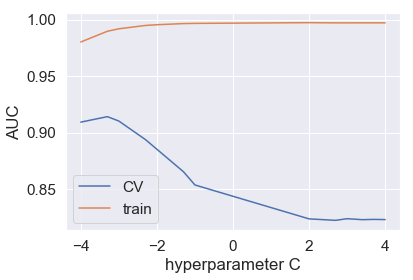

In [61]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l2',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, final_std_data, y_train, cv=10, scoring=auc)
    log_reg.fit(final_std_data,y_train)
    y_pred_proba = log_reg.predict_proba(final_std_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [62]:
log_reg = LogisticRegression(C=0.0005,max_iter=10000,tol=0.001)
log_reg.fit(final_std_data,y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)

In [63]:
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(vector.transform(tfidf_test)), y_test)*100))

accuracy = 90.47


In [64]:
predictions = log_reg.predict(standardizing.transform(vector.transform(tfidf_test)))

In [65]:
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision*100))
print ('Recall={0}'.format(Recall*100))
print ('f1_score={0}'.format(f1*100))

precision = 92.23831347387717
Recall=97.13513513513513
f1_score=94.62341325811


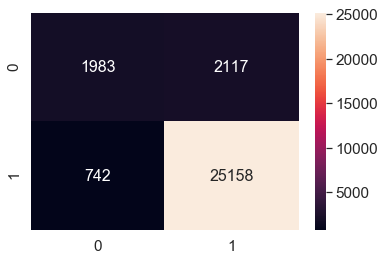

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

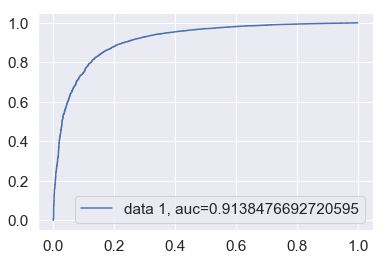

In [67]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(vector.transform(tfidf_test)))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### [4.2.1.1] Feature  Importance of TFIDF with l2 Regularizer

In [68]:
pos_indices = []
neg_indices = []
feat_names = vector.get_feature_names()
weights_before = log_reg.coef_
indices = list (np.argsort(weights_before[0]))
pos_indices = indices[-10:]
neg_indices = indices[0:10]
print ('top 10 positive features\t\t\ttop 10 negative features')
print ('-'*100)
for id1,id2 in zip(pos_indices,neg_indices):
    print ('\t{0}\t\t\t\t\t{1}'.format(feat_names[id1],feat_names[id2]))
   

top 10 positive features			top 10 negative features
----------------------------------------------------------------------------------------------------
	find					not
	nice					disappoint
	favorit					worst
	excel					aw
	perfect					terribl
	delici					horribl
	good					unfortun
	best					stale
	love					bland
	great					return


### [4.2.2] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

train scores
[0.5, 0.7909062733902787, 0.8726965565352625, 0.9483963491319725, 0.9687353694765786, 0.9898758876304536, 0.9930923945330418, 0.996916444406436, 0.9968450717023085, 0.9968524793868607, 0.9968864553595943, 0.9968278808063568, 0.9968336018668474]
**************************************************
CV scores
[0.5, 0.737474643725412, 0.8531336020054198, 0.9265739647008588, 0.9360879546733643, 0.9275145496070383, 0.9142671568962235, 0.8284336904344066, 0.8258115839003419, 0.8222634079189376, 0.8214420497154217, 0.8237924850604106, 0.8224520346486427]


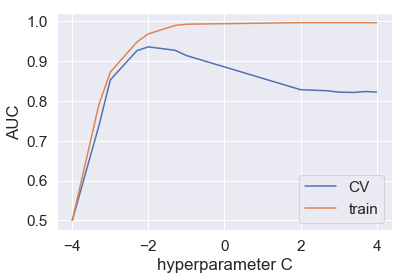

In [69]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l1',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, final_std_data, y_train, cv=10, scoring=auc)
    log_reg.fit(final_std_data,y_train)
    y_pred_proba = log_reg.predict_proba(final_std_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [70]:
log_reg = LogisticRegression(C=0.005,penalty='l1',max_iter=10000,tol=0.001)
log_reg.fit(final_std_data,y_train)

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [71]:
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(vector.transform(tfidf_test)), y_test)*100))

accuracy = 91.13333333333333


In [72]:
predictions = log_reg.predict(standardizing.transform(vector.transform(tfidf_test)))

In [73]:
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

precision = 0.916547175222254
Recall=0.9871814671814672
f1_score=0.9505539445311919


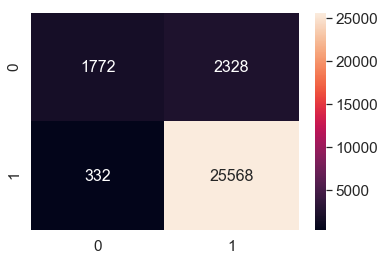

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

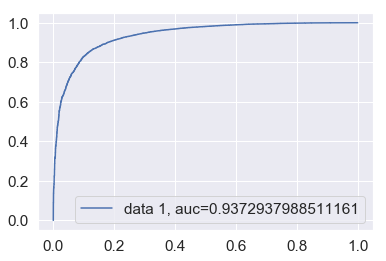

In [75]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(vector.transform(tfidf_test)))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### [4.2.2.1]Feature Importance of TFIDF with l1 regularization 

In [76]:
pos_indices = []
neg_indices = []
feat_names = vector.get_feature_names()
weights_before = log_reg.coef_
indices = list (np.argsort(weights_before[0]))
pos_indices = indices[-10:]
neg_indices = indices[0:10]
print ('top 10 positive features \t\t top 10 negative features')
print ('-'*100)
for id1,id2 in zip(pos_indices,neg_indices):
    print ('\t{0}\t\t\t\t\t{1}'.format(feat_names[id1],feat_names[id2]))
   

top 10 positive features 		 top 10 negative features
----------------------------------------------------------------------------------------------------
	find					not
	nice					disappoint
	favorit					worst
	excel					terribl
	good					aw
	perfect					horribl
	delici					return
	love					money
	best					threw
	great					unfortun


# [4.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

## [4.3.1] Applying Logistic Regression with L2 regularization on AVG W2V<font color='red'> SET 3</font>

In [77]:
import pickle 
with open("avg_w2v_train_data.pkl", "rb") as f:
    avg_w2v_train_data = pickle.load(f)

In [78]:
import pickle 
with open("avg_w2v_test_data.pkl", "rb") as f:
    avg_w2v_test_data = pickle.load(f)

In [79]:
standardizing  = StandardScaler(with_mean = False)
avg_w2v_std_train_data = standardizing.fit_transform(avg_w2v_train_data)
avg_w2v_std_train_data.shape

(70000, 300)

train scores
[0.9039903001300007, 0.9109722605770828, 0.912938977070425, 0.9162205654902067, 0.9168933998164115, 0.9182625861846088, 0.9187685496478182, 0.9186127071682118, 0.9190800821773921, 0.9186336771314563, 0.9186528120002114, 0.9186360368214579, 0.918610872073722]
**************************************************
CV scores
[0.9017952549247147, 0.9087825405111462, 0.910729067005892, 0.9134717315274579, 0.9142392642518248, 0.9153035101774499, 0.9153699457449465, 0.9158371425896131, 0.9156984118217302, 0.9156940071990342, 0.9157228896462861, 0.9157465360364453, 0.9158369842211569]


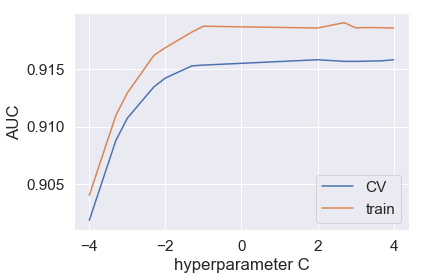

In [80]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l2',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, avg_w2v_std_train_data, y_train, cv=10, scoring=auc)
    log_reg.fit(avg_w2v_std_train_data,y_train)
    y_pred_proba = log_reg.predict_proba(avg_w2v_std_train_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [81]:
log_reg = LogisticRegression(C=0.05,penalty='l2',max_iter=10000,tol=0.001)
log_reg.fit(avg_w2v_std_train_data,y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [82]:
predictions = log_reg.predict(standardizing.transform(avg_w2v_test_data))
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(avg_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 81.02333333333334
precision = 0.9090651443378275
Recall=0.8669111969111969
f1_score=0.8874878950176881


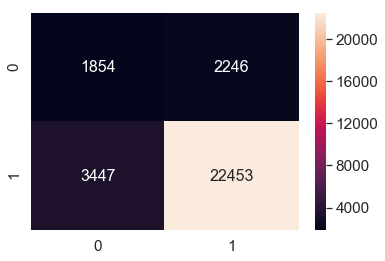

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

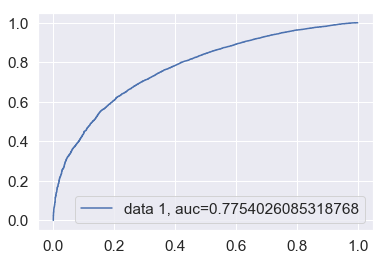

In [84]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(avg_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## [4.3.2] Applying Logistic Regression with L1 regularization on AVG W2V,<font color='red'> SET 3</font>

train scores
[0.596049529536806, 0.8629598876454986, 0.891350149489925, 0.9090660408341188, 0.9120050109759238, 0.9147767954974264, 0.9152018049648908, 0.9161072350431385, 0.9157835912858548, 0.9159524259177105, 0.915878291663623, 0.9158564091021479, 0.9157999190737187]
**************************************************
CV scores
[0.5127810767906871, 0.8380087759880162, 0.8837906321494697, 0.905839213257182, 0.9097132125417524, 0.9126881639968716, 0.9132312886183958, 0.9137318418192102, 0.913718182539838, 0.9133167778908133, 0.913548441248569, 0.9135966248514553, 0.9134416415207252]


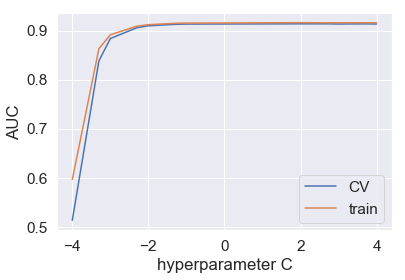

In [85]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l1',max_iter=10000,)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, avg_w2v_std_train_data, y_train, cv=10, scoring=auc)
    log_reg.fit(avg_w2v_std_train_data,y_train)
    y_pred_proba = log_reg.predict_proba(avg_w2v_std_train_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [89]:
log_reg = LogisticRegression(C=0.05,penalty='l1',max_iter=10000,tol=0.001)
log_reg.fit(avg_w2v_std_train_data,y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [90]:
predictions = log_reg.predict(standardizing.transform(avg_w2v_test_data))
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(avg_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 86.45666666666668
precision = 0.8645941162720807
Recall=0.9996911196911197
f1_score=0.9272476587820296


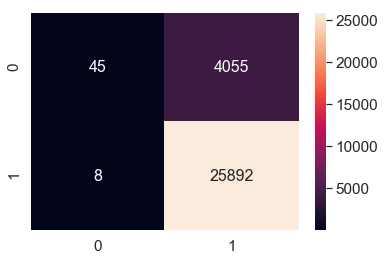

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

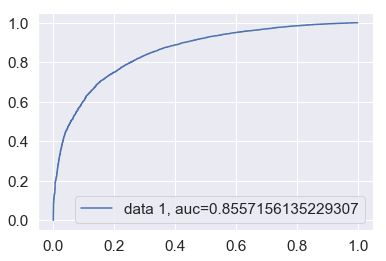

In [93]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(avg_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# [4.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

## [4.4.1] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [95]:
import pickle 
with open("tfidf_w2v_train_data.pkl", "rb") as f:
    tfidf_w2v_train_data = pickle.load(f)

In [96]:
import pickle 
with open("tfidf_w2v_test_data.pkl", "rb") as f:
    tfidf_w2v_test_data = pickle.load(f)

In [97]:
standardizing  = StandardScaler(with_mean = False)
tfidf_w2v_std_train_data = standardizing.fit_transform(tfidf_w2v_train_data)
tfidf_w2v_std_train_data.shape

(70000, 300)

In [98]:
tfidf_w2v_std_train_data.mean()

0.0071627058222749704

train scores
[0.8316270587156991, 0.843892458117977, 0.8469494345355281, 0.8522581075246595, 0.8540400931523262, 0.8568322715718129, 0.8574984999537762, 0.857940708235615, 0.8586533207588779, 0.8590636910421456, 0.8579022821092541, 0.8578925226531231, 0.8579026384382811]
**************************************************
CV scores
[0.8265845605404006, 0.8399606573161972, 0.8429660551070757, 0.8476368060962354, 0.8492059009670573, 0.8512725994261915, 0.8519668372492903, 0.8522394289550196, 0.8526927091715726, 0.8521712909266158, 0.8522005989890946, 0.8521940069020932, 0.8523305996958138]


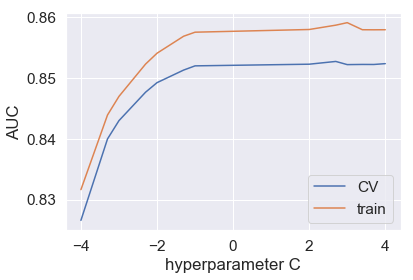

In [99]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l2',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, tfidf_w2v_std_train_data, y_train, cv=5, scoring=auc)
    log_reg.fit(tfidf_w2v_std_train_data,y_train)
    y_pred_proba = log_reg.predict_proba(tfidf_w2v_std_train_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [110]:
log_reg = LogisticRegression(C=0.01,penalty='l2',max_iter=10000,tol=0.001)
log_reg.fit(tfidf_w2v_std_train_data,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [111]:
predictions = log_reg.predict(standardizing.transform(tfidf_w2v_test_data))
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(tfidf_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 76.42
precision = 0.8806308127780025
Recall=0.8408494208494208
f1_score=0.8602804661268022


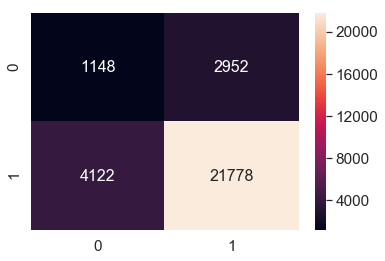

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

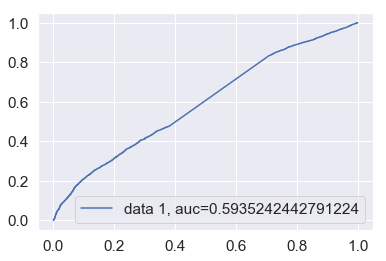

In [113]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(tfidf_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## [4.4.2] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

train scores
[0.5633358424835658, 0.7540617737940192, 0.8097770102846455, 0.8395026884035292, 0.845292490702287, 0.8508584985759706, 0.8509498474812783, 0.8534691293357572, 0.853501387010738, 0.8534165985187403, 0.8530253334101421, 0.8531025142774112, 0.8532963889418433]
**************************************************
CV scores
[0.5582377926129428, 0.7205708054481125, 0.7946056041449776, 0.8355777409967038, 0.8409341878103402, 0.8468424497145508, 0.8472910184695234, 0.8490297259572432, 0.8490785034418413, 0.8489612118037556, 0.849059330960578, 0.8489434448425431, 0.8485939751492177]


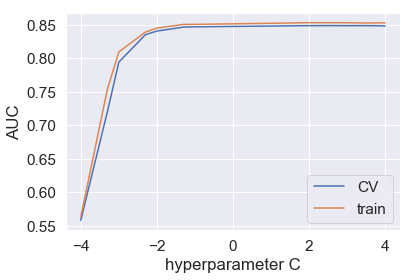

In [114]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
# creating list for hyperparameter alpha
alpha_values = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,100,500,1000,2500,5000,10000]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for alpha in alpha_values:
    log_reg = LogisticRegression(C=alpha,penalty='l1',max_iter=10000)
    auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
    auc_scores = cross_val_score(log_reg, tfidf_w2v_std_train_data, y_train, cv=5, scoring=auc)
    log_reg.fit(tfidf_w2v_std_train_data,y_train)
    y_pred_proba = log_reg.predict_proba(tfidf_w2v_std_train_data)[::,1]
    train_auc = roc_auc_score(y_train, y_pred_proba)
    train_auc_values.append(train_auc)
    cv_scores.append(auc_scores.mean())

print ('train scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

# changing to misclassification error

log = [math.log10(x) for x in alpha_values]
# plot misclassification error vs alpha 
plt.plot(log, cv_scores,label='CV')
#plt.label('cv_f1')
plt.plot(log,train_auc_values,label='train')
#plt.label('train_f1')
plt.legend()
plt.xlabel('hyperparameter C')
plt.ylabel('AUC')
plt.show()

In [115]:
log_reg = LogisticRegression(C=0.05,penalty='l1',max_iter=10000,tol=0.001)
log_reg.fit(tfidf_w2v_std_train_data,y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

In [116]:
predictions = log_reg.predict(standardizing.transform(tfidf_w2v_test_data))
print('accuracy = {0}'.format(log_reg.score(standardizing.transform(tfidf_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 77.99333333333334
precision = 0.8777699475373894
Recall=0.8656370656370657
f1_score=0.8716612884413515


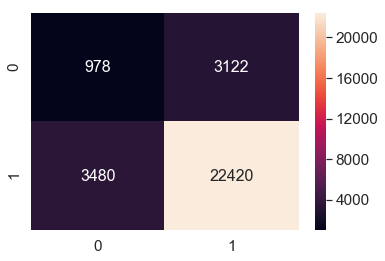

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

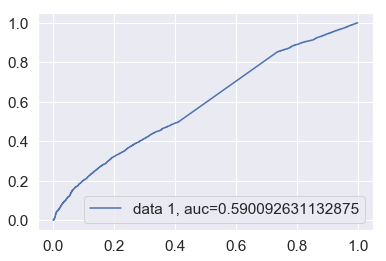

In [118]:
y_pred_proba = log_reg.predict_proba(standardizing.transform(tfidf_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 5) Tabular form of Results

In [119]:
from prettytable import PrettyTable 

x = PrettyTable()

x.field_names = ['Featurization','regularization','accuracy','AUC',
                 'precision','recall','f1_score']
x.add_row(['BOW','l2','92.51','0.931','0.9667','0.8784','0.9202'])
x.add_row(['BOW','l1','87.346','0.8829','0.8935','0.9688','0.9291'])
x.add_row(['TFIDF','l2','90.47','0.9138','0.9223','0.9713','0.9462'])
x.add_row(['TF-IDF','l1','91.13','0.937','0.916','0.9878','0.9505'])
x.add_row(['Avg W2V','l2','81.023','0.7754','0.9091','0.86','0.8875'])
x.add_row(['Avg W2V','l1','86.45','0.8557','0.86459','0.9974','0.9272'])
x.add_row(['TFIDF W2V','l2','76.42','0.593','0.8808','0.8408','0.8602'])
x.add_row(['TFIDF W2V','l1','77.99','0.590','0.8777','0.8656','0.8716'])
print (x)


+---------------+----------------+----------+--------+-----------+--------+----------+
| Featurization | regularization | accuracy |  AUC   | precision | recall | f1_score |
+---------------+----------------+----------+--------+-----------+--------+----------+
|      BOW      |       l2       |  92.51   | 0.931  |   0.9667  | 0.8784 |  0.9202  |
|      BOW      |       l1       |  87.346  | 0.8829 |   0.8935  | 0.9688 |  0.9291  |
|     TFIDF     |       l2       |  90.47   | 0.9138 |   0.9223  | 0.9713 |  0.9462  |
|     TF-IDF    |       l1       |  91.13   | 0.937  |   0.916   | 0.9878 |  0.9505  |
|    Avg W2V    |       l2       |  81.023  | 0.7754 |   0.9091  |  0.86  |  0.8875  |
|    Avg W2V    |       l1       |  86.45   | 0.8557 |  0.86459  | 0.9974 |  0.9272  |
|   TFIDF W2V   |       l2       |  76.42   | 0.593  |   0.8808  | 0.8408 |  0.8602  |
|   TFIDF W2V   |       l1       |  77.99   | 0.590  |   0.8777  | 0.8656 |  0.8716  |
+---------------+----------------+---------

# 6) Conclusions

1) TFIDF with l1 regularizer Values has high values of preacision, recall , f1 score  
   and it also has highest AUC. 

2) BOW with l2 regularizer has auc close to TFIDF,but low recall and f1_score and 
   there is high multicollinearity in BOW with l2 regularizer

3) so, TFIDF with l1 regularizer is a best vector.